# Prepare bird data
Create a CSV file containing the bird count for a given species.

In [36]:
using CSV
using PyPlot
using Dates
using DelimitedFiles
using DataFrames
using DIVAnd
using Test
const plt = PyPlot
using Conda
using PyCall
mpl = pyimport("matplotlib")
mpl.style.use("./emodnet.mplstyle")
ccrs = pyimport("cartopy.crs")
cfeature = pyimport("cartopy.feature") 
coast_f = cfeature.GSHHSFeature(scale="full")
coast_h = cfeature.GSHHSFeature(scale="h")
coast_i = cfeature.GSHHSFeature(scale="i")
datacrs = ccrs.PlateCarree();

## Data
Downloaded from https://www.vliz.be/en/imis?module=dataset&dasid=3117. 

> Vanermen N, Stienen EWM, Fijn R, Markones N, Holdsworth N, Osypchuk A, Pinto C, Desmet P (2022): European Seabirds at Sea (ESAS). ICES, Copenhagen, Denmark. https://esas.ices.dk. https://doi.org/10.14284/601

Two files are processed:
- `event.txt`: it gives the data set ID, the position and the date
- `occurrence.txt`: it gives the count for different taxa, and relate them to the eventID read from the previous fole. 

In [48]:
domain = (-55, 21, 14., 80.)
doplot = false

myspecies = "Larus fuscus"

datadir = "../../data"

datafileevent = joinpath(datadir, "event.txt")
datafileoccur = joinpath(datadir, "occurrence.txt")

# The "small" files, used for testing, are obtained by taking the first 200 lines of the 
# initial files
datafileevent2 = joinpath(datadir, "event_small.txt")
datafileoccur2 = joinpath(datadir, "occurrence200.csv")

isfile(datafileevent) & isfile(datafileoccur)

true

## Read data as dataframes
### Events

In [4]:
@time dataevents, header = readdlm(datafileevent, '\t', header=true);
events = DataFrame(dataevents, vec(header));

 10.518852 seconds (93.88 M allocations: 3.493 GiB, 16.53% gc time, 4.52% compilation time)


In [5]:
# Keep only "sub-samples" events 
# (otherwise no coordinates)
events = events[events.type .== "subSample",:];

### Occurences

In [6]:
@time dataoccur, header = readdlm(datafileoccur, '\t', header=true);
occurences = DataFrame(dataoccur, vec(header));

 22.263674 seconds (158.66 M allocations: 5.565 GiB, 55.56% gc time)


In [7]:
# Subset dataframe according to the select species
occurences_species = occurences[occurences.scientificName .== myspecies,:];

### Compute the total number of occurences per event

In [8]:
function get_total_count(occurences::DataFrame)
    
    total_count = Dict{String, Int64}()
    for (eventID, count) in zip(occurences.id, occurences_species.individualCount)
        @debug("$eventID → $count")

        # If the key was already found in the Dict, add the index to the list
        if haskey(total_count, eventID)
            total_count[eventID] += count
        else
            total_count[eventID] = count
        end
    end

    return total_count::Dict
end

get_total_count (generic function with 1 method)

In [9]:
@time total_count = get_total_count(occurences_species);

  0.181572 seconds (2.23 M allocations: 77.155 MiB, 19.02% compilation time)


In [25]:
function parse_date(xx::SubString{String}, regexdate=r"\d{4}-\d{2}-\d{2}/\d{4}-\d{2}-\d{2}"::Regex)
    thedateformat = Dates.DateFormat("yyyy-mm-ddTHH:MM:SSZ") # example: 1993-08-14T07:54:00Z
    mm = match(regexdate, xx)
    if mm !== nothing
        datestring = mm.match[1:10]
    else
        datestring = xx
    end
    thedate = DateTime(datestring, thedateformat)
    return thedate::DateTime
end

parse_date (generic function with 4 methods)

In [26]:
transform!(events, "eventDate" => ByRow(parse_date) => "eventDate");

## Make some plots
### Histogram

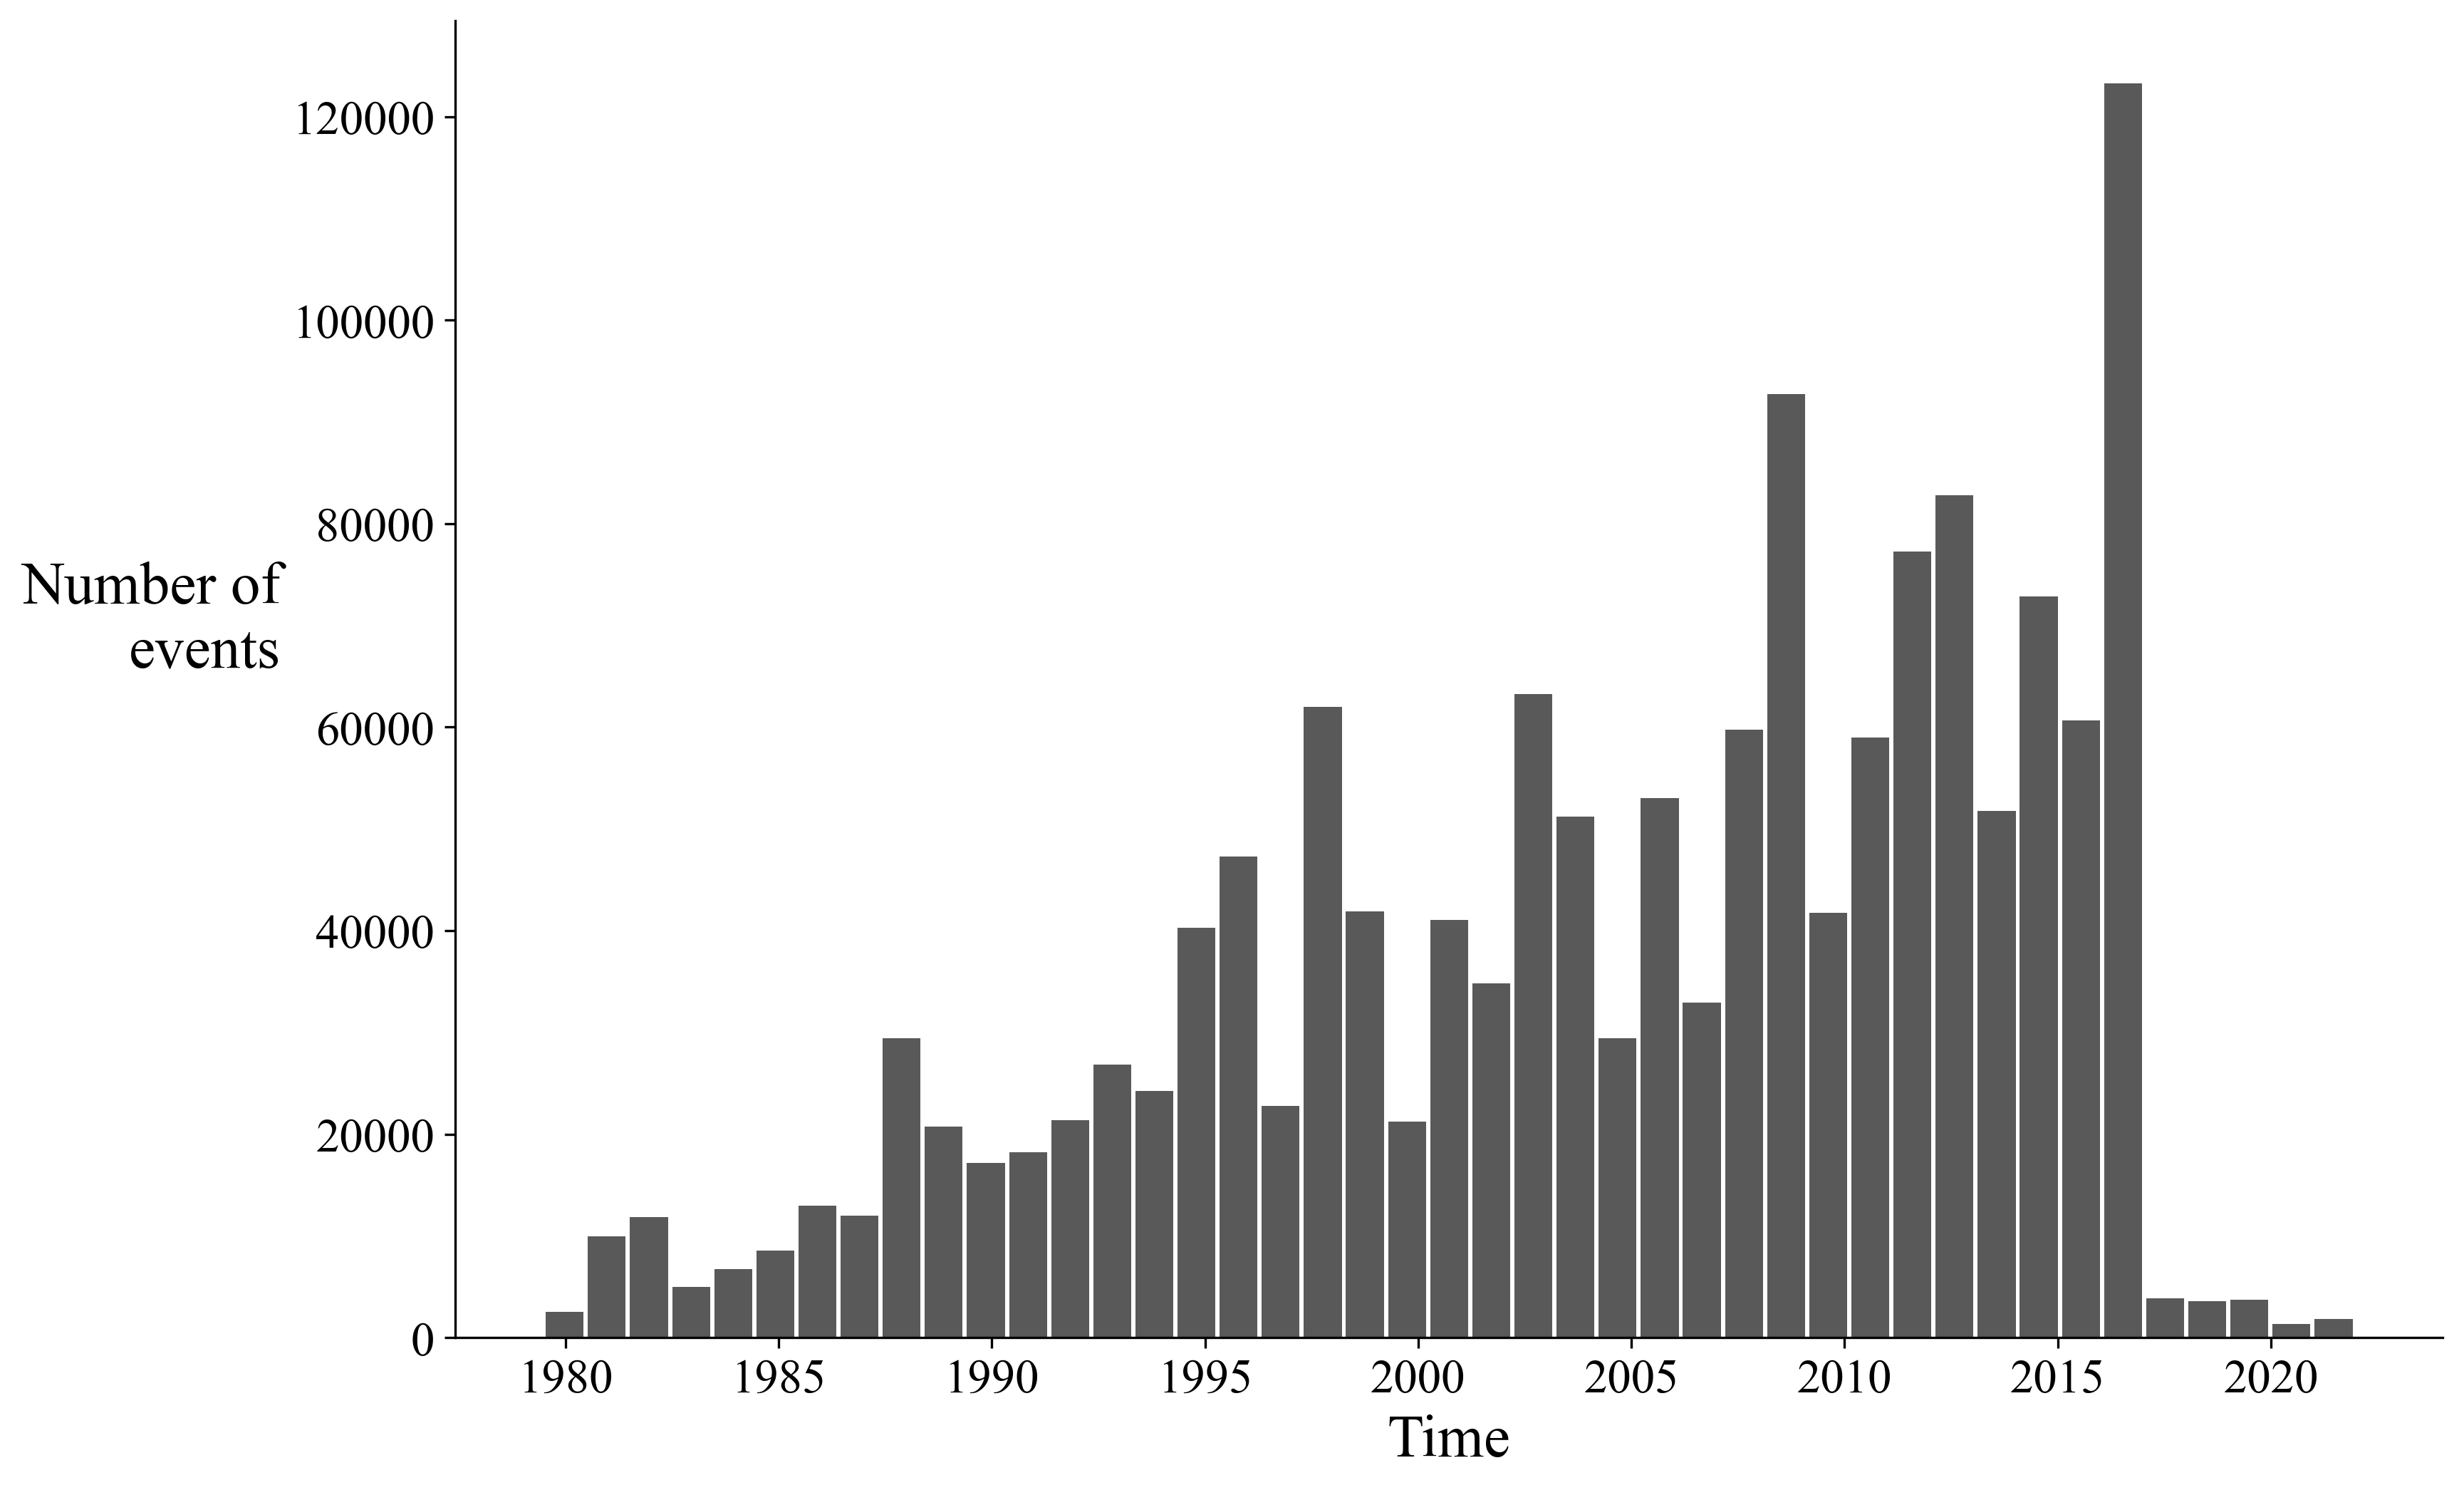

PyObject Text(393.25000000000006, 0.5, 'Number of\nevents')

In [29]:
yearmin = minimum(Dates.year.(events.eventDate))
yearmax = maximum(Dates.year.(events.eventDate))
fig = plt.figure()
ax = plt.subplot(111)
ax.spines["right"].set_visible(false)
ax.spines["top"].set_visible(false)
ax.hist(events.eventDate, bins=1-yearmin+yearmax, rwidth=0.9, color=".35");
ax.set_xlabel("Time")
ax.set_ylabel("Number of\nevents", rotation=0, ha="right")

### Locations

In [32]:
doplot = true

true

sys:1: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


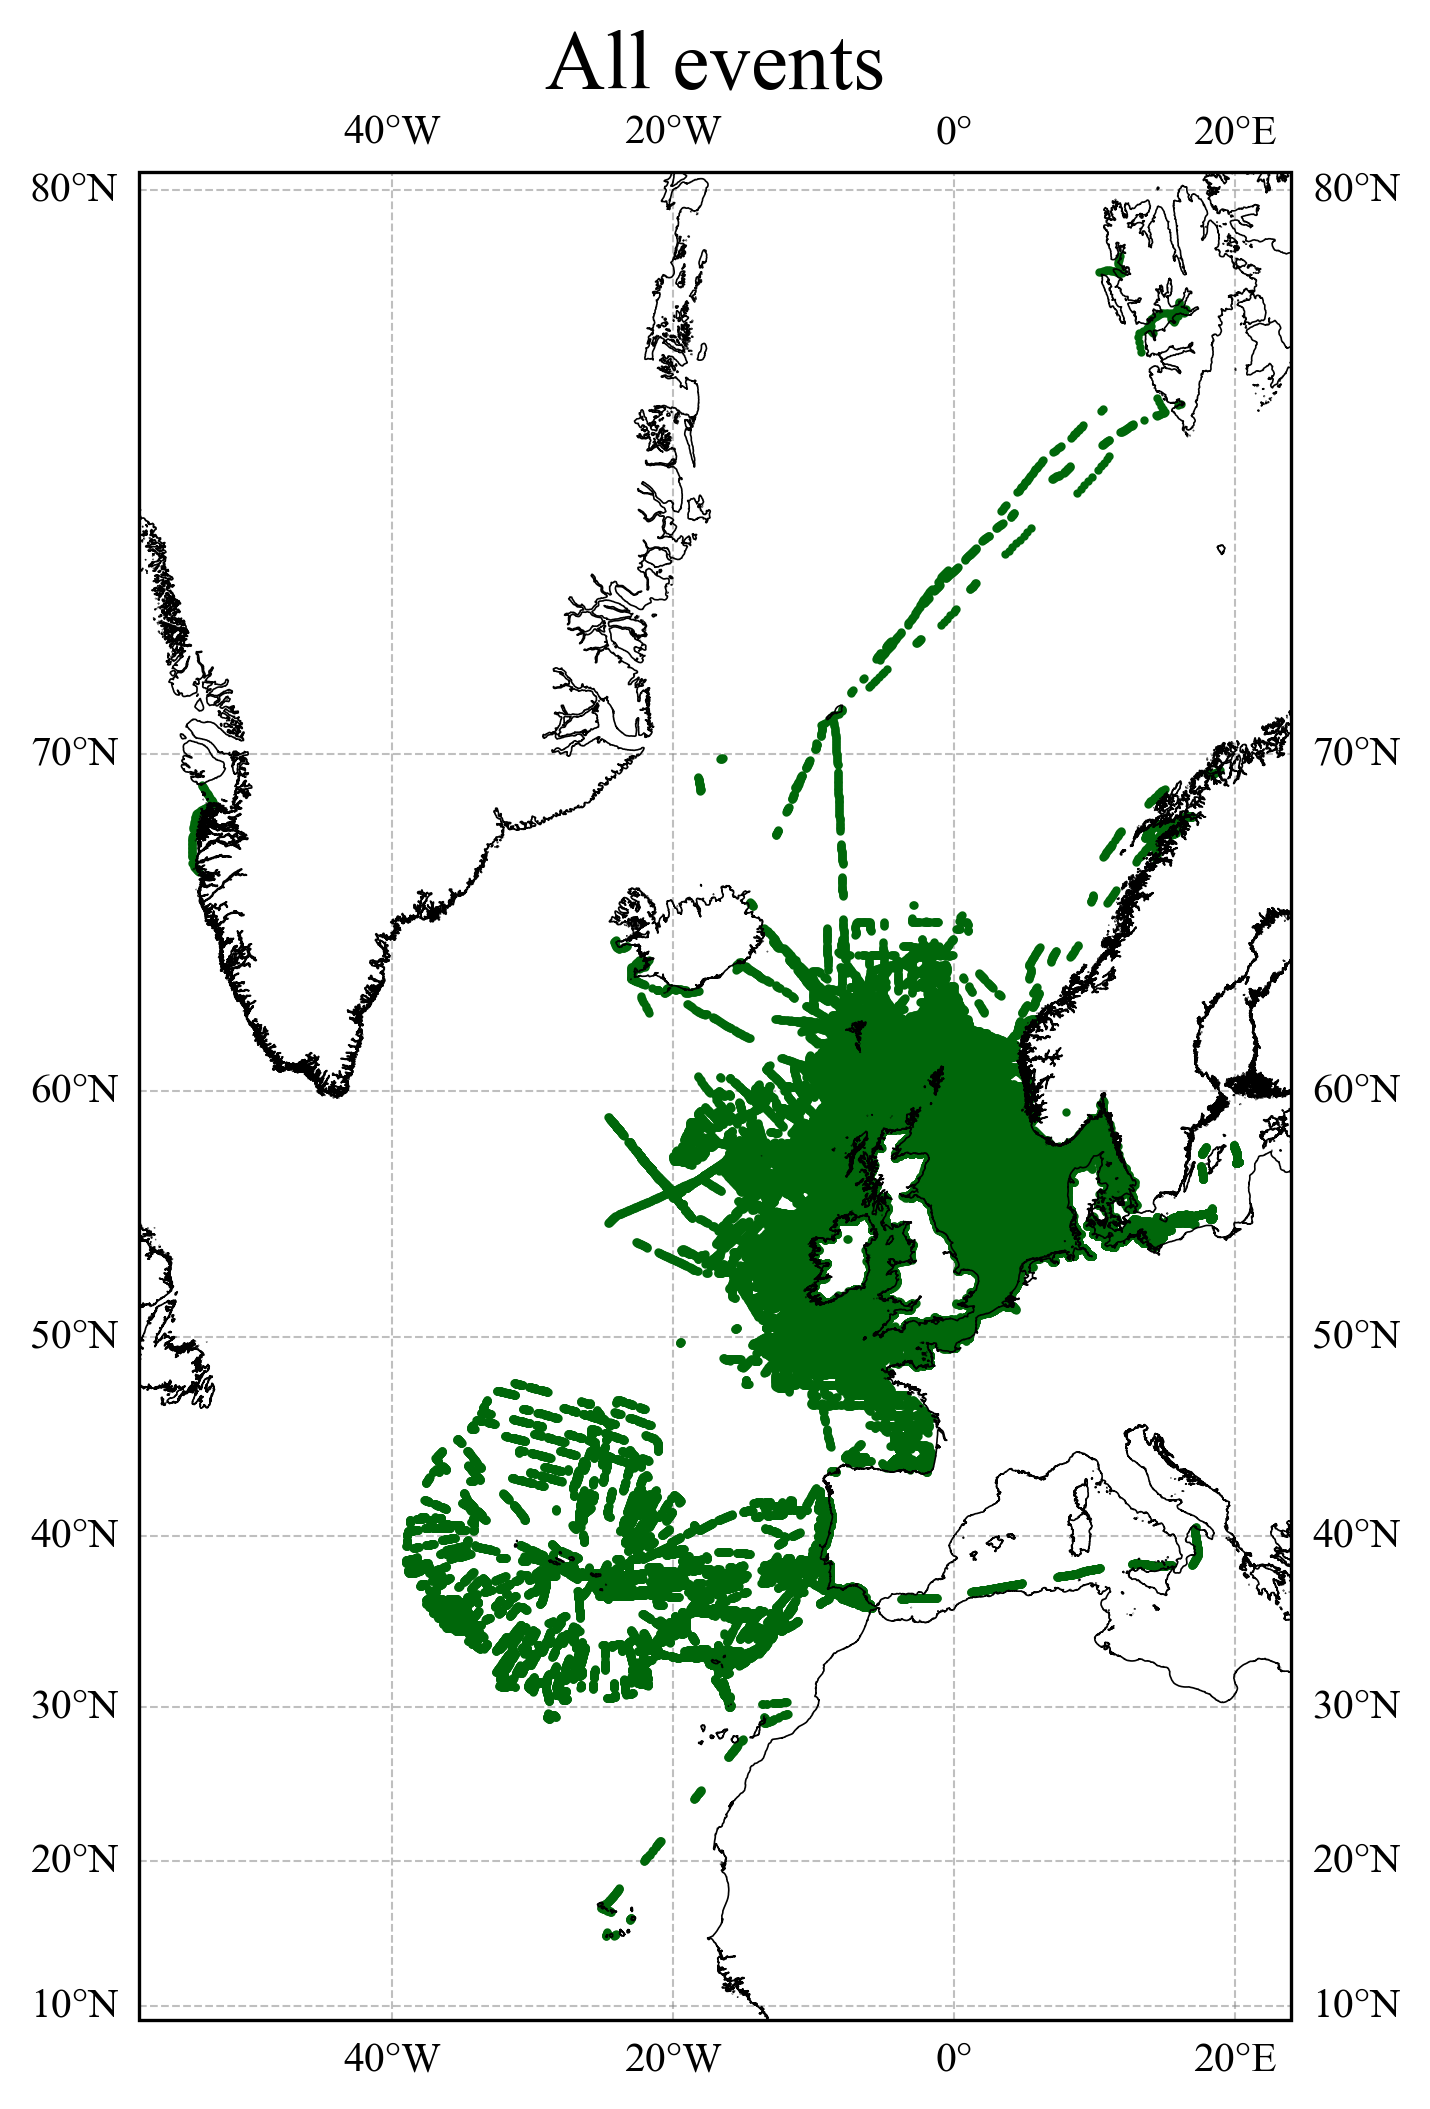

In [43]:
if doplot
    fig = plt.figure(figsize=(12, 8))
    ax = plt.subplot(111, projection=ccrs.Mercator())
    ax.plot(events.decimalLongitude, events.decimalLatitude, "o", 
        color="#00670A", ms=1, transform=datacrs, zorder=3)
    ax.add_feature(coast_h, lw=.4, zorder=4)
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=true,
                      linewidth=.5, color="gray", alpha=0.5, linestyle="--")
    gl.xlabels_top = false
    gl.ylabels_right = false
    ax.set_title("All events")
    plt.show()
end

## Write the data in a file

In [49]:
myspecies_ = replace(myspecies, " "=>"_")
fname = joinpath(datadir, "$(myspecies_).csv")

"../../data/Larus_fuscus.csv"

In [64]:
total_count_df = DataFrame(eventID=collect(keys(total_count)), total_count=collect(values(total_count)));

### Joint the dataframes

In [74]:
total_count_coordinates = innerjoin(total_count_df, events, on = :eventID);
select!(total_count_coordinates, :decimalLongitude, :decimalLatitude, :eventDate, :total_count);

In [75]:
total_count_coordinates

Row,decimalLongitude,decimalLatitude,eventDate,total_count
,Any,Any,DateTime,Int64
1,4.705,53.095,1993-08-14T06:04:00,3
2,4.71,53.1233,1993-08-14T06:15:00,2
3,4.715,53.15,1993-08-14T06:25:00,5
4,4.72,53.1767,1993-08-14T06:34:00,2
5,4.725,53.2033,1993-08-14T06:45:00,1
6,4.73,53.2317,1993-08-14T06:54:00,1
7,4.7417,53.2883,1993-08-14T07:15:00,4
8,4.75,53.345,1993-08-14T07:34:00,1
9,4.7717,53.6333,1993-08-14T09:15:00,1


### Write CSV

In [76]:
CSV.write(fname, total_count_coordinates)

"../../data/Larus_fuscus.csv"

## Compute heatmap
### Set resolution

In [77]:
deltalon = 1.
deltalat = 1.
lonr = domain[1]:deltalon:domain[2]
latr = domain[3]:deltalat:domain[4]

14.0:1.0:80.0

In [113]:
mask, (pm,pn), (xi,yi) = DIVAnd.DIVAnd_rectdom(lonr, latr)

(Bool[1 1 … 1 1; 1 1 … 1 1; … ; 1 1 … 1 1; 1 1 … 1 1], ([1.0 1.0 … 1.0 1.0; 1.0 1.0 … 1.0 1.0; … ; 1.0 1.0 … 1.0 1.0; 1.0 1.0 … 1.0 1.0], [1.0 1.0 … 1.0 1.0; 1.0 1.0 … 1.0 1.0; … ; 1.0 1.0 … 1.0 1.0; 1.0 1.0 … 1.0 1.0]), ([-55.0 -55.0 … -55.0 -55.0; -54.0 -54.0 … -54.0 -54.0; … ; 20.0 20.0 … 20.0 20.0; 21.0 21.0 … 21.0 21.0], [14.0 15.0 … 79.0 80.0; 14.0 15.0 … 79.0 80.0; … ; 14.0 15.0 … 79.0 80.0; 14.0 15.0 … 79.0 80.0]))

In [79]:
bathname = joinpath(datadir, "gebco_30sec_4.nc")
isfile(bathname) ? @info("Bathymetry file already downloaded") : download("https://dox.uliege.be/index.php/s/RSwm4HPHImdZoQP/download", bathname)

[ Info: Bathymetry file already downloaded


In [110]:
xi, yi, maskbathy = DIVAnd.load_mask(bathname, true , lonr, latr, 0.0)

(-55.0:1.0:21.0, 14.0:1.0:80.0, Bool[1 1 … 0 0; 1 1 … 0 0; … ; 0 0 … 0 0; 0 0 … 1 0])

### Perform heatmap computation

In [120]:
@time dens1, LHM, LCV, LSCV = DIVAnd.DIVAnd_heatmap(mask, (pm,pn), (xi,yi), 
    (total_count_coordinates.decimalLongitude[1:1000], total_count_coordinates.decimalLatitude[1:1000]), 
    ones(1000), 20.)

@time dens2, LHM, LCV, LSCV = DIVAnd.DIVAnd_heatmap(maskbathy, (pm,pn), (xi,yi), 
    (total_count_coordinates.decimalLongitude[1:1000], total_count_coordinates.decimalLatitude[1:1000]), 
    ones(1000), 20.)

  0.428774 seconds (112.53 k allocations: 820.627 MiB, 8.57% gc time)
  0.336847 seconds (112.85 k allocations: 643.577 MiB, 8.61% gc time)


([2.168844365647622e-5 2.299565407266624e-5 … NaN NaN; 2.306690185271814e-5 2.468395371577683e-5 … NaN NaN; … ; NaN NaN … NaN NaN; NaN NaN … 0.0004027057532119215 NaN], 20.0, -6.440910508241787, -0.0026944528237928668)

sys:1: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


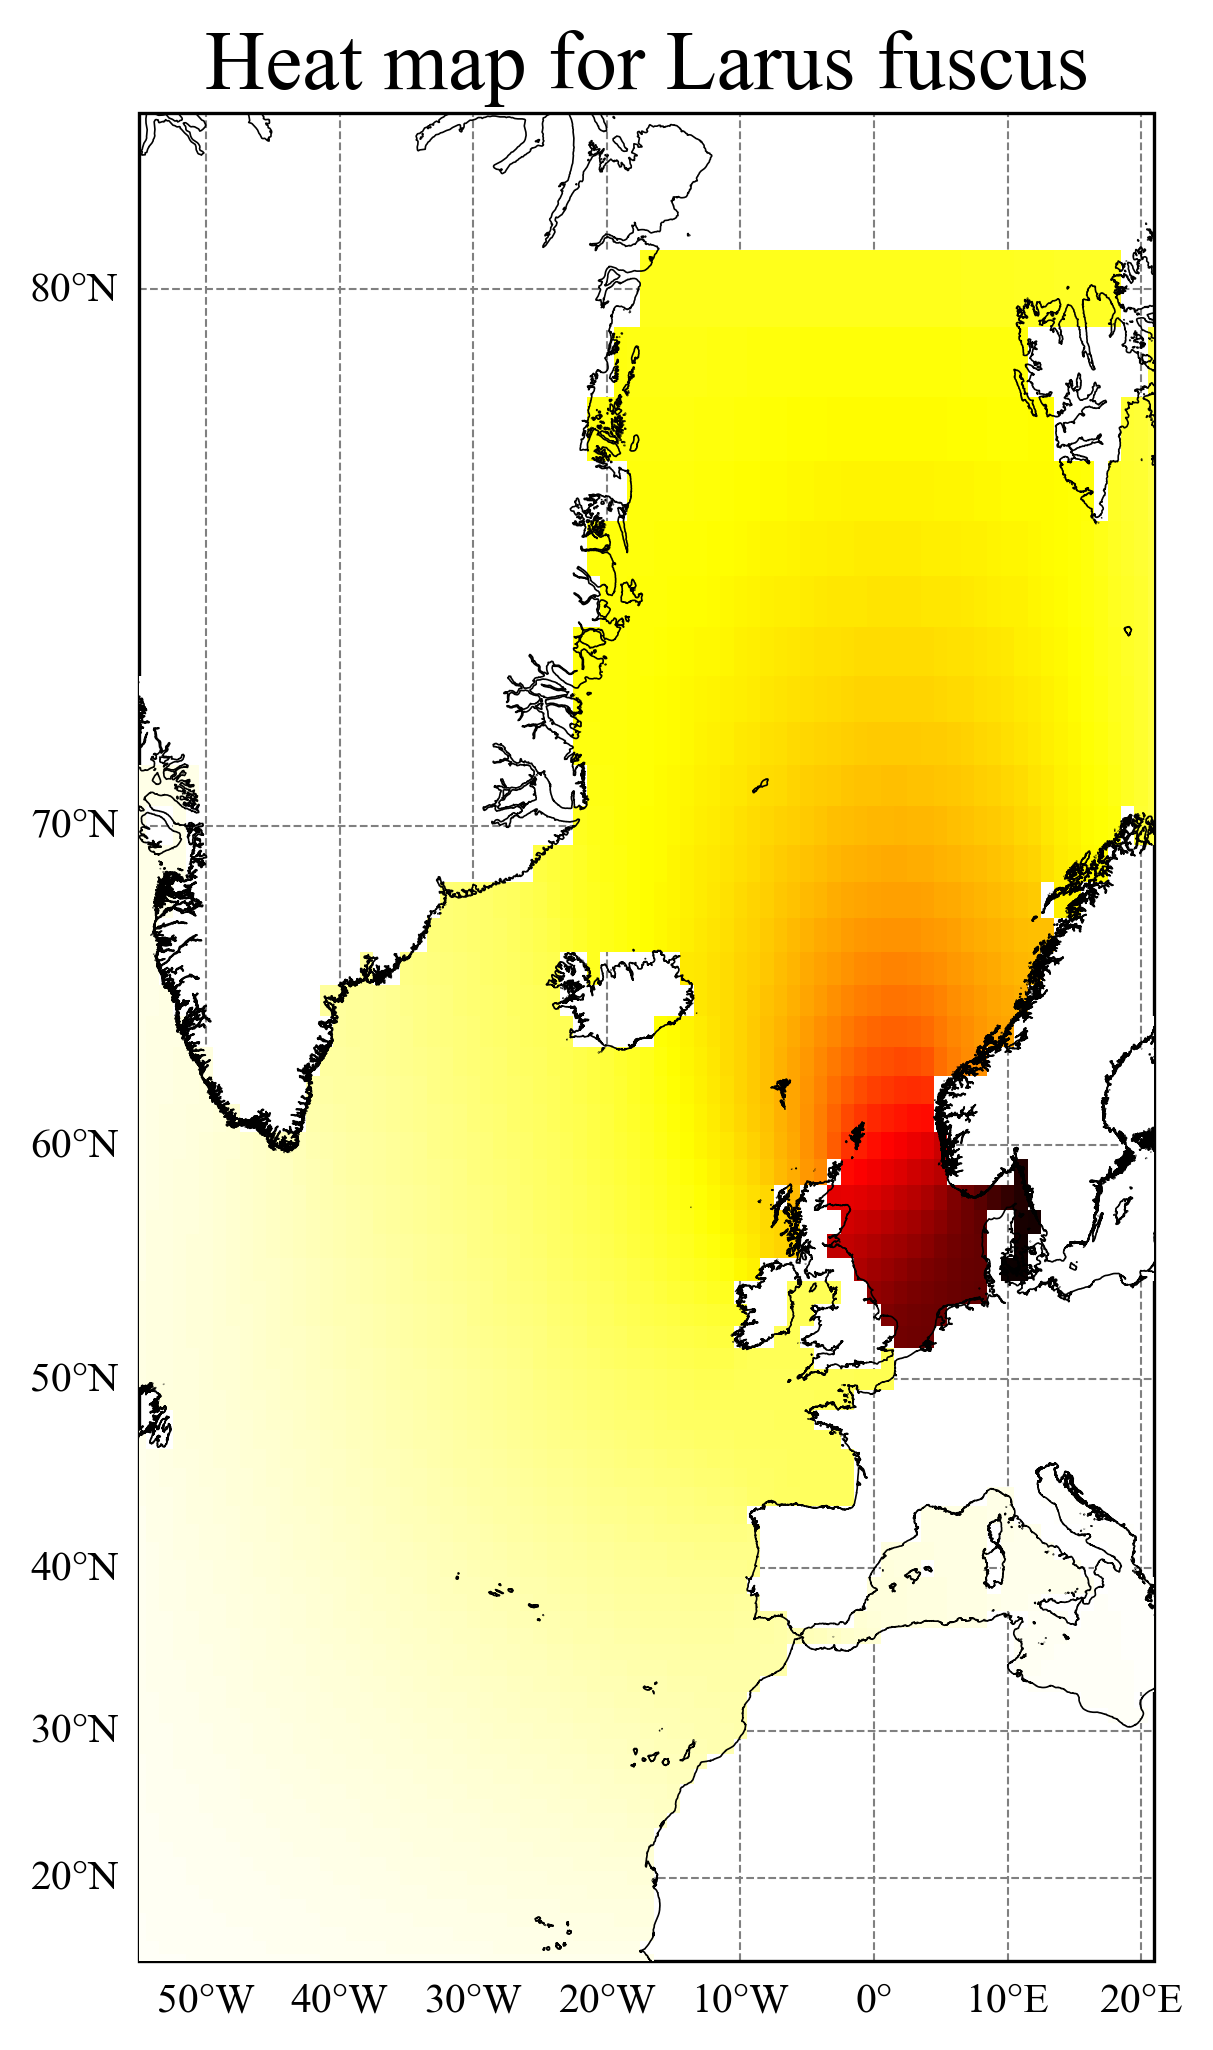

In [134]:
doplot = true
if doplot
    fig = plt.figure(figsize=(12, 8))
    ax = plt.subplot(111, projection=ccrs.Mercator())
    ax.set_extent(domain)
    ax.pcolormesh(xi, yi, dens2, transform=datacrs, zorder=3, cmap=plt.cm.hot_r)
    ax.add_feature(coast_h, lw=.4, zorder=5)
    
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=true, zorder=2,
                      linewidth=.5, color="gray", alpha=1, linestyle="--")
    gl.top_labels  = false
    gl.right_labels = false
    ax.set_title("Heat map for $(myspecies)")
    plt.show()
end